Loaded 2622 rows (without noise)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 47.79it/s]


Prepared 2622 sequences
Train size: 2097, Test size: 525


C:\Users\ved\Desktop\Speech-Completition-Prediction\python\.venv\Lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking (Masking)                    │ (None, None, 384)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │           1,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 272,212 (1.04 MB)

 Trainable params: 272,212 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 547ms/step - accuracy: 0.0716 - loss: 2.9506 - val_accuracy: 0.1657 - val_loss: 2.4749
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 35s 525ms/step - accuracy: 0.2625 - loss: 2.0648 - val_accuracy: 0.3886 - val_loss: 1.4683
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 36s 538ms/step - accuracy: 0.5121 - loss: 1.2938 - val_accuracy: 0.5010 - val_loss: 1.0766
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 35s 535ms/step - accuracy: 0.6027 - loss: 0.9259 - val_accuracy: 0.5752 - val_loss: 1.0098
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 35s 523ms/step - accuracy: 0.6069 - loss: 1.0074 - val_accuracy: 0.6419 - val_loss: 0.8213
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 36s 547ms/step - accuracy: 0.7298 - loss: 0.6781 - val_accuracy: 0.7390 - val_loss: 0.6598
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 34s 511ms/step - accuracy: 0.7643 - loss: 0.5961 - val_accuracy: 0.7886 - val_loss: 0.5705
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 35s 525ms/step - accuracy: 0.7841 - loss: 0.5229 - val_accu

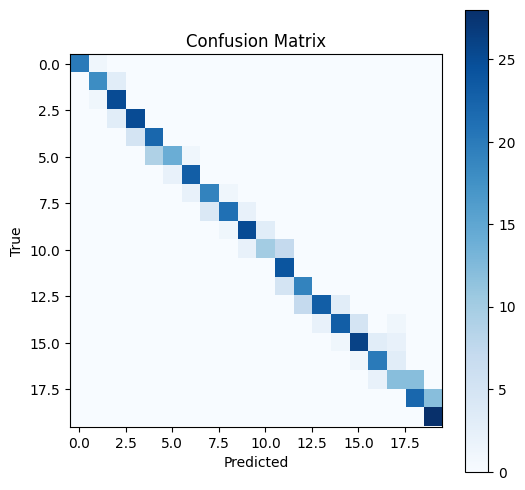

In [1]:
# Import
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Params
INPUT_PATH = "./progress_added.csv"
NUM_CLASSES = 20   # progress bins: 0 to n-1
EMBED_DIM = 384   # MiniLM embedding size

# Load data
df = pd.read_csv(INPUT_PATH)
df = df[df["cluster"] != -1]
df = df[df["text"].notnull() & df["text"].str.strip().astype(bool)]
print(f"Loaded {len(df)} rows (without noise)")

# Prepare sequences

# convert embedding string to list
df["embedding"] = df["embedding"].apply(lambda x: np.array(eval(x), dtype=np.float32))

X = []
y = []

for file_name, group in tqdm(df.groupby("file")):
    group = group.sort_values("start_sec")
    
    sequence = []
    for i, row in group.iterrows():
        sequence.append(row["embedding"])
        X.append(sequence.copy())
        y.append(int(row["progress_label"]))

print(f"Prepared {len(X)} sequences")

# Pad sequences
X_padded = pad_sequences(X, dtype='float32', padding='post')

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y, test_size=0.2, random_state=42
)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

# Build LSTM model
model = models.Sequential([
    layers.Masking(mask_value=0.0, input_shape=(None, EMBED_DIM)),
    layers.LSTM(128, return_sequences=False),
    layers.Dense(64, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Train
history = model.fit(
    X_train, np.array(y_train),
    validation_data=(X_test, np.array(y_test)),
    epochs=10,
    batch_size=32
)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, np.array(y_test))
print(f"\nTest Accuracy: {test_acc:.4f}")

# Classification report
y_pred = model.predict(X_test).argmax(axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()
